Data Loaded: 15000 training examples, 5640 test examples.
Input Dimensions: 8 (10D)
Optimization started...


100%|██████████| 20000/20000 [05:19<00:00, 62.53it/s, init loss: 1871647488.0000, avg. loss [19001-20000]: 16398.0723]



SVI elapsed time: 322.08347845077515


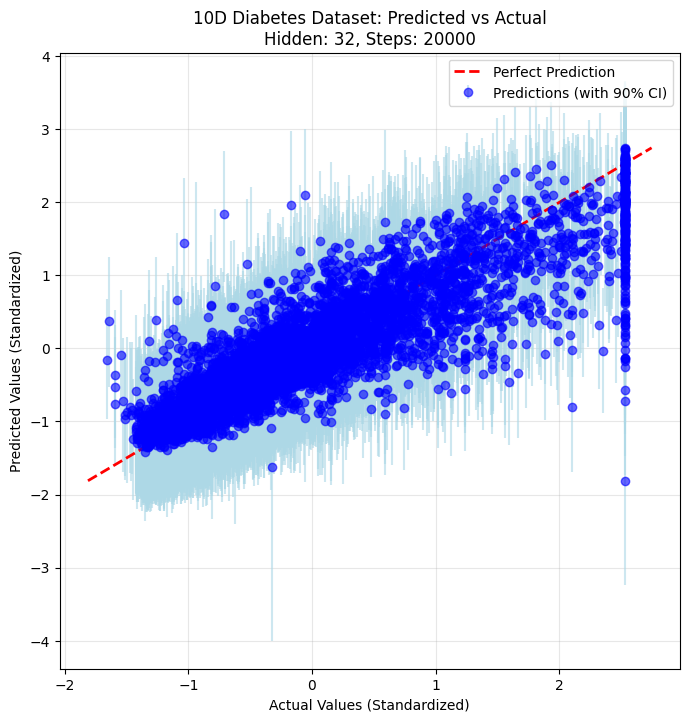

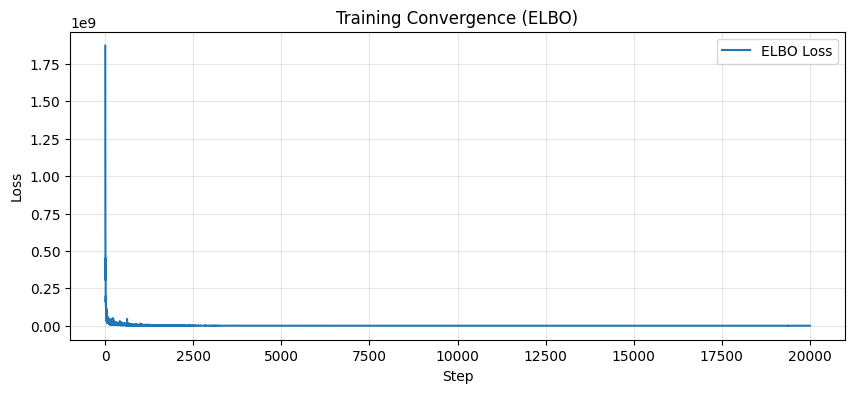


Final RMSE on Test Set: 0.4777


In [9]:
import time
import matplotlib.pyplot as plt
import numpy as np
from jax import random
import jax.numpy as jnp
from jax.nn import silu
import numpyro
from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoLowRankMultivariateNormal
import numpyro.distributions as dist
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from jax import jit
# 1. Define the same BNN model (No changes needed here!)
def nonlin(x):
    return silu(x)

def model(X, Y, D_H, D_Y=1):
    N, D_X = X.shape
    
    # Standard BNN layers
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))
    z1 = nonlin(jnp.matmul(X, w1))
    
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))
    z2 = nonlin(jnp.matmul(z1, w2))

    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))
    z4 = nonlin(jnp.matmul(z2, w3))

    w4 = numpyro.sample("w4", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
    z3 = jnp.matmul(z4, w4)
    
    # Observation noise
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)
    
    # Observe data
    with numpyro.plate("data", N, subsample_size=N): # Note: subsample_size can be used for mini-batching
        numpyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1), obs=Y)

# 2. SVI Training Function
def run_svi(model, args, rng_key, X, Y, D_H):
    start = time.time()
    
    # A. The Guide: Automatically approximates the posterior as a Normal distribution
    guide = AutoLowRankMultivariateNormal(model, rank = 10)
    
    # B. The Optimizer: Adam is standard for SVI
    optimizer = numpyro.optim.Adam(step_size=args.learning_rate)
    
    # C. The Loss: ELBO (Evidence Lower Bound)
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    # D. Run the optimization loop
    print("Optimization started...")
    svi_result = svi.run(rng_key, args.num_steps, X, Y, D_H)
    print("\nSVI elapsed time:", time.time() - start)
    
    # Return the learned variational parameters (means and stds of the weights)
    return svi_result.params, guide, svi_result.losses

# 3. Data Generation (Updated for 5D)
def get_data_sklearn(args):
    # 1. Load the 10D Diabetes Dataset
    # X shape: (442, 10), Y shape: (442,)
    X_raw, Y_raw = fetch_california_housing(return_X_y=True)
    Y_raw = Y_raw[:, np.newaxis] # Reshape to (N, 1)

    # 2. Split into Train (350) and Test (92)
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_raw, Y_raw, train_size=15000, random_state=42
    )

    # 3. Standardize (CRITICAL for SVI)
    # We calculate stats on TRAINING data only to avoid "data leakage"
    mean_x, std_x = X_train.mean(axis=0), X_train.std(axis=0)
    mean_y, std_y = Y_train.mean(axis=0), Y_train.std(axis=0)

    # Apply to Train
    X_train_scaled = (X_train - mean_x) / std_x
    Y_train_scaled = (Y_train - mean_y) / std_y
    
    # Apply SAME stats to Test
    X_test_scaled = (X_test - mean_x) / std_x
    Y_test_scaled = (Y_test - mean_y) / std_y

    # 4. Convert to JAX arrays
    return (
        jnp.array(X_train_scaled), 
        jnp.array(Y_train_scaled), 
        jnp.array(X_test_scaled), 
        jnp.array(Y_test_scaled)
    )
def main(args):
    # 1. Get Real 10D Data
    X, Y, X_test, Y_test_true = get_data_sklearn(args)
    print(f"Data Loaded: {X.shape[0]} training examples, {X_test.shape[0]} test examples.")
    print(f"Input Dimensions: {X.shape[1]} (10D)")

    # 2. Run SVI Training
    rng_key, rng_predict = random.split(random.PRNGKey(0))
    svi_params, guide, losses = run_svi(model, args, rng_key, X, Y, args.num_hidden)
    
    # 3. Make Predictions
    predictive = Predictive(model, guide=guide, params=svi_params, num_samples=1000)
    
    # JIT compile the prediction for speed
    @jit
    def get_predictions(rng_key, X_test):
        return predictive(rng_key, X_test, None, args.num_hidden)["Y"]

    samples = get_predictions(rng_predict, X_test)
    
    # Calculate Mean and Error Bars (90% CI)
    mean_prediction = jnp.mean(samples, axis=0)[..., 0]
    percentiles = np.percentile(samples, [5.0, 95.0], axis=0)[..., 0]
    # Error bars are the distance from the mean to the percentile
    y_err = np.stack([mean_prediction - percentiles[0], percentiles[1] - mean_prediction])

    # 4. NEW PLOT: Predicted vs Actual
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Scatter plot with error bars
    ax.errorbar(
        Y_test_true.flatten(), 
        mean_prediction.flatten(), 
        yerr=y_err, 
        fmt='o', 
        ecolor='lightblue', # Color of the error bars
        color='blue',       # Color of the dots
        alpha=0.6, 
        label='Predictions (with 90% CI)'
    )
    
    # Plot the ideal "Perfect Prediction" diagonal line
    min_val = min(Y_test_true.min(), mean_prediction.min())
    max_val = max(Y_test_true.max(), mean_prediction.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Perfect Prediction")
    
    ax.set_xlabel("Actual Values (Standardized)")
    ax.set_ylabel("Predicted Values (Standardized)")
    ax.set_title(f"10D Diabetes Dataset: Predicted vs Actual\nHidden: {args.num_hidden}, Steps: {args.num_steps}")
    ax.legend()
    plt.grid(True, alpha=0.3)

    # --- NEW PLOT: ELBO LOSS ---
    plt.figure(figsize=(10, 4))
    plt.plot(losses, label='ELBO Loss')
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Convergence (ELBO)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    # 5. Numerical Score
    rmse = jnp.sqrt(jnp.mean((mean_prediction - Y_test_true.flatten())**2))
    print(f"\nFinal RMSE on Test Set: {rmse:.4f}")
    
    plt.show()

# Update Args for this dataset
class Args:
    # num_data is ignored now (determined by dataset size)
    num_hidden = 32      # 32 is plenty for this dataset size
    learning_rate = 5e-3  
    num_steps = 20000     # 10k steps is enough for convergence
    device = "cpu"        # or "gpu"
    num_chains = 1        # Helper for platform config

# Run it
args = Args()
numpyro.set_platform(args.device)
main(args)